Copyright (c) Microsoft Corporation. All rights reserved.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/regression-part2-automated-ml.png)

# Prediksi harga rumah dengan beberapa metode

Percobaan ini menggunakan beberapa metode analisis regresi yang terdapat di azure automl

## Prerequisites

## Prepare data

In [1]:
import pandas as pd
from azureml.core import Dataset
from datetime import datetime
from dateutil.relativedelta import relativedelta

Mengambil dataset yang sebelumnya sudah di upload di github

Persiapan data hanya menghapus data id karena data tersebut tidak digunakan

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/danfxa/MSAI/main/MariBisnis.csv')
data = data.drop(columns = 'id')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### Cleanse data 

Menjalankan `describe()` akan menampilkan statistik dari data.

In [26]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


## Configure workspace


Create a workspace object from the existing workspace. A [Workspace](https://docs.microsoft.com/python/api/azureml-core/azureml.core.workspace.workspace?view=azure-ml-py) is a class that accepts your Azure subscription and resource information. It also creates a cloud resource to monitor and track your model runs. `Workspace.from_config()` reads the file **config.json** and loads the authentication details into an object named `ws`. `ws` is used throughout the rest of the code in this tutorial.

In [5]:
from azureml.core.workspace import Workspace
ws = Workspace.from_config()

## Membagi data menjadi data training dan data testing

Proses membagi ini bertujuan untuk mengetahui seberapa akurat model yang digunakan dengan menggunakan hasil konfigurasi dari training data yang diterapkan pada data testing yang kemudian dibandingkan antara hasil prediksi dengan nilai yang sesungguhnya (target)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(data, test_size=0.2, random_state=223)

## Automatically train a model

### Define training settings

Define the experiment parameter and model settings for training. View the full list of [settings](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-auto-train). Submitting the experiment with these default settings will take approximately 20 minutes, but if you want a shorter run time, reduce the `experiment_timeout_hours` parameter.


|Property| Value in this tutorial |Description|
|----|----|---|
|**iteration_timeout_minutes**|10|Time limit in minutes for each iteration. Increase this value for larger datasets that need more time for each iteration.|
|**experiment_timeout_hours**|0.3|Maximum amount of time in hours that all iterations combined can take before the experiment terminates.|
|**enable_early_stopping**|True|Flag to enable early termination if the score is not improving in the short term.|
|**primary_metric**| spearman_correlation | Metric that you want to optimize. The best-fit model will be chosen based on this metric.|
|**featurization**| auto | By using auto, the experiment can preprocess the input data (handling missing data, converting text to numeric, etc.)|
|**verbosity**| logging.INFO | Controls the level of logging.|
|**n_cross_validations**|5|Number of cross-validation splits to perform when validation data is not specified.|

In [16]:
import logging

automl_settings = {
    "iteration_timeout_minutes": 10,
    "experiment_timeout_hours": 0.3,
    "enable_early_stopping": True,
    "primary_metric": 'spearman_correlation',
    "featurization": 'auto',
    "verbosity": logging.INFO,
    "n_cross_validations": 5
}

In [17]:
from azureml.train.automl import AutoMLConfig

automl_config = AutoMLConfig(task='regression',
                             debug_log='automated_ml_errors.log',
                             training_data=x_train,
                             label_column_name="price",
                             **automl_settings)

Proses otomatis ini sudah menangani preprosesing data dan memilih model yang bagus

### Train the automatic regression model

Create an experiment object in your workspace. An experiment acts as a container for your individual runs. Pass the defined `automl_config` object to the experiment, and set the output to `True` to view progress during the run. 

After starting the experiment, the output shown updates live as the experiment runs. For each iteration, you see the model type, the run duration, and the training accuracy. The field `BEST` tracks the best running training score based on your metric type.

In [18]:
from azureml.core.experiment import Experiment
experiment = Experiment(ws, "capstone")
local_run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
capstone,AutoML_4e6b9a31-fdbd-4404-8114-29953371ae80,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed

Cannot serialize JSON possibly due to timestamp, retrying


## Explore the results

Explore the results of automatic training with a [Jupyter widget](https://docs.microsoft.com/python/api/azureml-widgets/azureml.widgets?view=azure-ml-py). The widget allows you to see a graph and table of all individual run iterations, along with training accuracy metrics and metadata. Additionally, you can filter on different accuracy metrics than your primary metric with the dropdown selector.

In [20]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Retrieve the best model

Select the best model from your iterations. The `get_output` function returns the best run and the fitted model for the last fit invocation. By using the overloads on `get_output`, you can retrieve the best run and fitted model for any logged metric or a particular iteration.

In [21]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: capstone,
Id: AutoML_4e6b9a31-fdbd-4404-8114-29953371ae80_20,
Type: None,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='regression', working_dir='/mnt/batch/ta...
), random_state=None, reg_alpha=1.275, reg_lambda=0.825, subsample=0.9, subsample_freq=7))], verbose=False)), ('1', Pipeline(memory=None, steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('xgboostregressor', XGBoostRegressor(n_jobs=1, problem_info=ProblemInfo(
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=0, tree_method='auto'))], verbose=False))], weights=[0.4, 0.2, 0.06666666666666667, 0.26666666666666666, 

### Test the best model accuracy

Use the best model to run predictions on the test data set to predict taxi fares. The function `predict` uses the best model and predicts the values of y, **trip cost**, from the `x_test` data set. Print the first 10 predicted cost values from `y_predict`.

In [23]:
y_test = x_test.pop("price")

y_predict = fitted_model.predict(x_test)
print(y_predict[:10])

[ 780047.86384769  982726.22060548  339086.32350731  521014.57551736
  451141.53251081  589577.7420506  2106454.8253411   286630.6239526
  423477.60617199  905163.97597772]


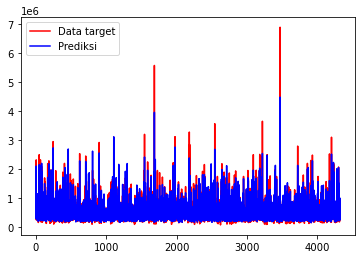

In [44]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(1,4323,4323)
fig,ax = plt.subplots()
ax.plot(x,y_test,color = 'r',label = 'Data target')
ax.plot(x,y_predict,color='b', label = 'Prediksi')
plt.legend()
plt.show()

Calculate the `root mean squared error` of the results. Convert the `y_test` dataframe to a list to compare to the predicted values. The function `mean_squared_error` takes two arrays of values and calculates the average squared error between them. Taking the square root of the result gives an error in the same units as the y variable, **cost**. It indicates roughly how far the taxi fare predictions are from the actual fares.

In [24]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_actual = y_test.values.flatten().tolist()
rmse = sqrt(mean_squared_error(y_actual, y_predict))
rmse

119908.72055655869

Run the following code to calculate mean absolute percent error (MAPE) by using the full `y_actual` and `y_predict` data sets. This metric calculates an absolute difference between each predicted and actual value and sums all the differences. Then it expresses that sum as a percent of the total of the actual values.

In [25]:
sum_actuals = sum_errors = 0

for actual_val, predict_val in zip(y_actual, y_predict):
    abs_error = actual_val - predict_val
    if abs_error < 0:
        abs_error = abs_error * -1

    sum_errors = sum_errors + abs_error
    sum_actuals = sum_actuals + actual_val

mean_abs_percent_error = sum_errors / sum_actuals
print("Model MAPE:")
print(mean_abs_percent_error)
print()
print("Model Accuracy:")
print(1 - mean_abs_percent_error)

Model MAPE:
0.12470105621928483

Model Accuracy:
0.8752989437807152


From the two prediction accuracy metrics, you see that the model is fairly good at predicting taxi fares from the data set's features, typically within +- $4.00, and approximately 15% error. 

The traditional machine learning model development process is highly resource-intensive, and requires significant domain knowledge and time investment to run and compare the results of dozens of models. Using automated machine learning is a great way to rapidly test many different models for your scenario.

## Clean up resources

Do not complete this section if you plan on running other Azure Machine Learning service tutorials.

### Stop the notebook VM

If you used a cloud notebook server, stop the VM when you are not using it to reduce cost.

1. In your workspace, select **Compute**.
1. Select the **Notebook VMs** tab in the compute page.
1. From the list, select the VM.
1. Select **Stop**.
1. When you're ready to use the server again, select **Start**.

### Delete everything

If you don't plan to use the resources you created, delete them, so you don't incur any charges.

1. In the Azure portal, select **Resource groups** on the far left.
1. From the list, select the resource group you created.
1. Select **Delete resource group**.
1. Enter the resource group name. Then select **Delete**.

You can also keep the resource group but delete a single workspace. Display the workspace properties and select **Delete**.

## Next steps

In this automated machine learning tutorial, you did the following tasks:

> * Configured a workspace and prepared data for an experiment.
> * Trained by using an automated regression model locally with custom parameters.
> * Explored and reviewed training results.

[Deploy your model](https://docs.microsoft.com/azure/machine-learning/service/tutorial-deploy-models-with-aml) with Azure Machine Learning service.